# Retinal Disease Detection Machine Learning
* Uses Retinal Disease Detection dataset from kaggle
  * https://www.kaggle.com/datasets/mohamedabdalkader/retinal-disease-detection

Goal:
Train a single CNN backbone with two heads to predict:
* Retinopathy grade (multi-class classification, e.g., 0–4)
* Risk of macular edema (binary classification: 0/1)

The notebook goes through:
1. Imports Configuration
2. Transforms
3. Robust Image Path Resolver
4. Dataset Class
5. Handling Class Imbalance and Dataloaders
6. Model Architecture: Shared Backbone + Two Heads
7. Training and Validation
8. Learning Curves and Diagnostics
9. Test Set Evaluation
10. Inference on a Single Image
11. Save Final Model
12. Grad-CAM for the Two-Head Model

# Imports and Configuration

In [1]:
# Import libraries
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
# Configuration
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

BASE_PATH = 'C:/Users/Iamsc/Retinal Disease Detection'

TRAIN_CSV = os.path.join(BASE_PATH, 'train', 'annotations.csv')
VALID_CSV = os.path.join(BASE_PATH, 'valid', 'annotations.csv')
TEST_CSV  = os.path.join(BASE_PATH, 'test',  'annotations.csv')

TRAIN_IMG_DIR = os.path.join(BASE_PATH, 'train', 'images')
VALID_IMG_DIR = os.path.join(BASE_PATH, 'valid', 'images')
TEST_IMG_DIR  = os.path.join(BASE_PATH, 'test',  'images')

IMG_SIZE   = 384   # higher than 224 helps medical images
BATCH_SIZE = 16
ACCUM_STEPS = 1    # set >1 to simulate larger batch sizes
EPOCHS     = 12
LR_BACKBONE = 1e-4
LR_HEADS    = 1e-3
WEIGHT_RETINOPATHY = 1.0
WEIGHT_ME         = 1.0  # loss weights for multi-task
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(DEVICE)


cuda


# Transforms

In [3]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

valid_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

#  Robust Image Path Resolver

In [4]:
def resolve_image_path(img_dir, img_name):
    candidate = os.path.join(img_dir, img_name)
    if os.path.exists(candidate):
        return candidate
    # try alternative extensions
    base, ext = os.path.splitext(img_name)
    for alt in ['.jpg', '.jpeg', '.png', '.JPG', '.PNG', '.JPEG']:
        alt_path = os.path.join(img_dir, base + alt)
        if os.path.exists(alt_path):
            return alt_path
    # As a last resort, search by basename ignoring extension
    prefix = base.lower()
    for f in os.listdir(img_dir):
        if os.path.splitext(f)[0].lower() == prefix:
            return os.path.join(img_dir, f)
    raise FileNotFoundError(f"Could not locate image for: {img_name}")

# Dataset Class

In [5]:
# Dataset (Multi-Task: Retinopathy grade + Macular Edema risk)
class RetinalMultiTaskDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        # Normalize column names exactly as provided
        self.img_col = 'Image name'
        self.dr_col  = 'Retinopathy grade'
        self.me_col  = 'Risk of macular edema'
        self.cap_col = 'Caption'  # not used yet
        self.img_dir = img_dir
        self.transform = transform

        # Ensure numeric dtypes
        self.df[self.dr_col] = self.df[self.dr_col].astype(int)
        self.df[self.me_col] = self.df[self.me_col].astype(int)

        # Store class counts
        self.dr_classes = sorted(self.df[self.dr_col].unique().tolist())
        self.me_classes = [0, 1]  # binary 0/1

        # Map retinopathy grades to contiguous indices if needed (e.g., {0,1,2,3,4})
        self.dr_to_idx = {c: i for i, c in enumerate(self.dr_classes)}
        self.idx_to_dr = {i: c for c, i in self.dr_to_idx.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        fname = row[self.img_col]
        img_path = resolve_image_path(self.img_dir, fname)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # targets
        dr_label = self.dr_to_idx[int(row[self.dr_col])]   # multi-class index
        me_label = int(row[self.me_col])                   # binary 0/1

        # Optionally include caption for multimodal work later
        caption = row.get('Caption', "")

        return image, torch.tensor(dr_label, dtype=torch.long), torch.tensor(me_label, dtype=torch.long), fname, caption


# Handling Class Imbalance and Dataloaders

In [6]:
train_ds = RetinalMultiTaskDataset(TRAIN_CSV, TRAIN_IMG_DIR, transform=train_tfms)
valid_ds = RetinalMultiTaskDataset(VALID_CSV, VALID_IMG_DIR, transform=valid_tfms)
test_ds  = RetinalMultiTaskDataset(TEST_CSV,  TEST_IMG_DIR,  transform=valid_tfms)

num_dr_classes = len(train_ds.dr_classes)
print("Retinopathy grade classes (original values):", train_ds.dr_classes)
print("Mapped to indices:", train_ds.dr_to_idx)

# Class weights for imbalance (DR head)
dr_counts = train_ds.df['Retinopathy grade'].value_counts().reindex(train_ds.dr_classes, fill_value=0).values
dr_class_weights = 1.0 / np.maximum(dr_counts, 1)  # inverse frequency
dr_class_weights = dr_class_weights / dr_class_weights.sum() * len(dr_class_weights)
dr_class_weights_tensor = torch.tensor(dr_class_weights, dtype=torch.float32).to(DEVICE)

# Optional Weighted Sampler (focus on rare DR grades)
sample_weights = train_ds.df['Retinopathy grade'].map(lambda x: dr_class_weights[train_ds.dr_to_idx[x]]).values
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Retinopathy grade classes (original values): [0, 1, 2, 3, 4]
Mapped to indices: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


# Model Architecture: Shared Backbone + Two Heads

In [7]:
class MultiTaskResNet(nn.Module):
    def __init__(self, num_dr_classes):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_feats = self.backbone.fc.in_features
        # Replace backbone fc with identity; we’ll add two heads
        self.backbone.fc = nn.Identity()
        # Heads
        self.dr_head = nn.Sequential(
            nn.Linear(in_feats, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_dr_classes)
        )
        self.me_head = nn.Sequential(
            nn.Linear(in_feats, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # binary (logits)
        )

    def forward(self, x):
        feats = self.backbone(x)
        dr_logits = self.dr_head(feats)
        me_logits = self.me_head(feats)
        return dr_logits, me_logits

model = MultiTaskResNet(num_dr_classes=num_dr_classes).to(DEVICE)

# Freeze some early layers at first (optional warm start)
for name, p in model.backbone.named_parameters():
    p.requires_grad = not (name.startswith("layer1.") or name.startswith("conv1") or name.startswith("bn1"))

# Losses & optimizer
criterion_dr = nn.CrossEntropyLoss(weight=dr_class_weights_tensor)  # Weighted DR loss
criterion_me = nn.CrossEntropyLoss()                                # Binary (as 2-class CE)
optimizer = optim.Adam([
    {"params": [p for n,p in model.backbone.named_parameters() if p.requires_grad], "lr": LR_BACKBONE},
    {"params": model.dr_head.parameters(), "lr": LR_HEADS},
    {"params": model.me_head.parameters(), "lr": LR_HEADS},
])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


# Training and Validation
- Until the loop at the last block before next section is code provided by ChatGPT to fix the loop from getting stuck.

In [8]:
# Quick sanity check (no DataLoader, just 1 sample)

# 1) Verify dataset length and fetch a single item without DataLoader
print("Train size:", len(train_ds))
sample = train_ds[0]  # will exercise __getitem__
print("Fetched one sample OK (image tensor shape if transformed):", sample[0].shape)

Train size: 1577
Fetched one sample OK (image tensor shape if transformed): torch.Size([3, 384, 384])


In [9]:
# Make the DataLoader “safe” (no workers, no sampler) and test

# Temporarily disable sampler/workers to isolate the issue
safe_train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0, pin_memory=False)
safe_valid_loader = DataLoader(valid_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=False)

# Try a single lightweight forward pass
model.eval()
for i, batch in enumerate(safe_train_loader):
    imgs, dr_t, me_t, _, _ = batch
    with torch.no_grad():
        _ = model(imgs.to(DEVICE))
    print(f"Iter {i}: OK")
    if i == 2:  # just a couple of iters to confirm
        break


Iter 0: OK
Iter 1: OK
Iter 2: OK


In [10]:
# Harden image loading (fixes corrupt/odd files + speeds up path lookups)

from PIL import ImageFile, UnidentifiedImageError
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Build a fast index: lowercase stem -> full path
def build_image_index(img_dir):
    index = {}
    for f in os.listdir(img_dir):
        stem = os.path.splitext(f)[0].lower()
        index.setdefault(stem, os.path.join(img_dir, f))
    return index

class RetinalMultiTaskDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_col = 'Image name'
        self.dr_col  = 'Retinopathy grade'
        self.me_col  = 'Risk of macular edema'
        self.cap_col = 'Caption'
        self.img_dir = img_dir
        self.transform = transform

        self.df[self.dr_col] = self.df[self.dr_col].astype(int)
        self.df[self.me_col] = self.df[self.me_col].astype(int)

        self.dr_classes = sorted(self.df[self.dr_col].unique().tolist())
        self.dr_to_idx = {c: i for i, c in enumerate(self.dr_classes)}
        self.idx_to_dr = {i: c for c, i in self.dr_to_idx.items()}

        # 🔥 Pre-index once (fixes the per-sample os.listdir cost)
        self.path_index = build_image_index(self.img_dir)

    def _resolve_path_fast(self, img_name):
        stem = os.path.splitext(img_name)[0].lower()
        p = self.path_index.get(stem)
        if p and os.path.exists(p):
            return p
        # final fallback, in case index missed something
        for ext in ['.png','.jpg','.jpeg','.PNG','.JPG','.JPEG']:
            cand = os.path.join(self.img_dir, stem + ext)
            if os.path.exists(cand):
                return cand
        raise FileNotFoundError(f"Missing image: {img_name}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        fname = row[self.img_col]
        try:
            img_path = self._resolve_path_fast(fname)
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, UnidentifiedImageError, OSError) as e:
            # Skip bad images by substituting a black image (keeps training flowing)
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0,0,0))

        if self.transform:
            image = self.transform(image)

        dr_label = self.dr_to_idx[int(row[self.dr_col])]
        me_label = int(row[self.me_col])
        caption  = row.get(self.cap_col, "")

        return image, torch.tensor(dr_label), torch.tensor(me_label), fname, caption

In [11]:
# Recreate datasets after this change
train_ds = RetinalMultiTaskDataset(TRAIN_CSV, TRAIN_IMG_DIR, transform=train_tfms)
valid_ds = RetinalMultiTaskDataset(VALID_CSV, VALID_IMG_DIR, transform=valid_tfms)
test_ds  = RetinalMultiTaskDataset(TEST_CSV,  TEST_IMG_DIR,  transform=valid_tfms)

In [12]:
# Safe loaders for training (then scale back up)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0, pin_memory=False)
valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

In [13]:
# Mini-epoch "smoke test"
def head_loader(loader, max_batches=5):
    for i, batch in enumerate(loader):
        yield batch
        if i+1 >= max_batches:
            break

# One quick pass through 5 batches
model.train()
for images, dr_t, me_t, _, _ in tqdm(head_loader(train_loader, 5), total=5):
    images, dr_t, me_t = images.to(DEVICE), dr_t.to(DEVICE), me_t.to(DEVICE)
    dr_logits, me_logits = model(images)
    loss = criterion_dr(dr_logits, dr_t) + criterion_me(me_logits, me_t)
    optimizer.zero_grad(); loss.backward(); optimizer.step()
print("Mini-epoch OK ✅")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]

Mini-epoch OK ✅


In [37]:
# Training & Validation Loop
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_dr_loss, total_me_loss, total = 0.0, 0.0, 0
    dr_correct, me_correct = 0, 0

    optimizer.zero_grad(set_to_none=True)
    for step, batch in enumerate(tqdm(loader, disable=False)):
        imgs, dr_t, me_t, _, _ = batch
        imgs, dr_t, me_t = imgs.to(DEVICE), dr_t.to(DEVICE), me_t.to(DEVICE)

        with torch.set_grad_enabled(train):
            dr_logits, me_logits = model(imgs)
            loss_dr = criterion_dr(dr_logits, dr_t)
            loss_me = criterion_me(me_logits, me_t)
            loss = WEIGHT_RETINOPATHY*loss_dr + WEIGHT_ME*loss_me

            if train:
                loss.backward()
                if (step + 1) % ACCUM_STEPS == 0:
                    optimizer.step()
                    optimizer.zero_grad(set_to_none=True)

        # metrics
        dr_pred = dr_logits.argmax(1)
        me_pred = me_logits.argmax(1)
        dr_correct += (dr_pred == dr_t).sum().item()
        me_correct += (me_pred == me_t).sum().item()
        total += imgs.size(0)
        total_dr_loss += loss_dr.item()
        total_me_loss += loss_me.item()

    avg_dr_loss = total_dr_loss / len(loader)
    avg_me_loss = total_me_loss / len(loader)
    dr_acc = dr_correct / total
    me_acc = me_correct / total
    return avg_dr_loss, avg_me_loss, dr_acc, me_acc

best_val_score = 0.0
history = {"train_dr_loss": [], "train_me_loss": [], "train_dr_acc": [], "train_me_acc": [],
           "val_dr_loss": [], "val_me_loss": [], "val_dr_acc": [], "val_me_acc": []}

for epoch in range(1, EPOCHS + 1):
    tr_dr_l, tr_me_l, tr_dr_a, tr_me_a = run_epoch(train_loader, train=True)
    va_dr_l, va_me_l, va_dr_a, va_me_a = run_epoch(valid_loader, train=False)

    # combined validation score (you can change weighting)
    val_score = 0.5*va_dr_a + 0.5*va_me_a
    scheduler.step(va_dr_l + va_me_l)

    history["train_dr_loss"].append(tr_dr_l)
    history["train_me_loss"].append(tr_me_l)
    history["train_dr_acc"].append(tr_dr_a)
    history["train_me_acc"].append(tr_me_a)
    history["val_dr_loss"].append(va_dr_l)
    history["val_me_loss"].append(va_me_l)
    history["val_dr_acc"].append(va_dr_a)
    history["val_me_acc"].append(va_me_a)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train DR Loss {tr_dr_l:.4f} Acc {tr_dr_a:.3f} | ME Loss {tr_me_l:.4f} Acc {tr_me_a:.3f} || "
          f"Val DR Loss {va_dr_l:.4f} Acc {va_dr_a:.3f} | ME Loss {va_me_l:.4f} Acc {va_me_a:.3f}")

    # Save best
    if val_score > best_val_score:
        best_val_score = val_score
        torch.save(model.state_dict(), "retina_multitask_best.pth")
        print("✅ Saved new best model.")

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.40it/s]


Epoch 01/12 | Train DR Loss 0.5611 Acc 0.743 | ME Loss 0.0779 Acc 0.969 || Val DR Loss 0.9050 Acc 0.667 | ME Loss 0.1587 Acc 0.947
✅ Saved new best model.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:16<00:00,  1.37it/s]


Epoch 02/12 | Train DR Loss 0.5188 Acc 0.759 | ME Loss 0.0652 Acc 0.977 || Val DR Loss 0.9974 Acc 0.655 | ME Loss 0.1530 Acc 0.941


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.39it/s]


Epoch 03/12 | Train DR Loss 0.4699 Acc 0.774 | ME Loss 0.0593 Acc 0.980 || Val DR Loss 0.9915 Acc 0.678 | ME Loss 0.1668 Acc 0.929


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.39it/s]


Epoch 04/12 | Train DR Loss 0.4308 Acc 0.795 | ME Loss 0.0519 Acc 0.983 || Val DR Loss 0.9851 Acc 0.658 | ME Loss 0.1666 Acc 0.947


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.40it/s]


Epoch 05/12 | Train DR Loss 0.4076 Acc 0.804 | ME Loss 0.0449 Acc 0.985 || Val DR Loss 1.0747 Acc 0.696 | ME Loss 0.1658 Acc 0.953
✅ Saved new best model.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.38it/s]


Epoch 06/12 | Train DR Loss 0.3805 Acc 0.824 | ME Loss 0.0424 Acc 0.984 || Val DR Loss 1.1870 Acc 0.684 | ME Loss 0.1720 Acc 0.941


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.39it/s]


Epoch 07/12 | Train DR Loss 0.3499 Acc 0.838 | ME Loss 0.0393 Acc 0.988 || Val DR Loss 1.0933 Acc 0.652 | ME Loss 0.1739 Acc 0.944


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.39it/s]


Epoch 08/12 | Train DR Loss 0.3340 Acc 0.836 | ME Loss 0.0357 Acc 0.989 || Val DR Loss 1.1327 Acc 0.649 | ME Loss 0.1640 Acc 0.953


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.38it/s]


Epoch 09/12 | Train DR Loss 0.3396 Acc 0.824 | ME Loss 0.0386 Acc 0.982 || Val DR Loss 1.1515 Acc 0.673 | ME Loss 0.1717 Acc 0.944


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.38it/s]


Epoch 10/12 | Train DR Loss 0.3069 Acc 0.841 | ME Loss 0.0335 Acc 0.986 || Val DR Loss 1.2030 Acc 0.702 | ME Loss 0.1831 Acc 0.947


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.39it/s]


Epoch 11/12 | Train DR Loss 0.2917 Acc 0.854 | ME Loss 0.0309 Acc 0.990 || Val DR Loss 1.2158 Acc 0.684 | ME Loss 0.1746 Acc 0.947


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.38it/s]

Epoch 12/12 | Train DR Loss 0.3103 Acc 0.848 | ME Loss 0.0287 Acc 0.990 || Val DR Loss 1.2275 Acc 0.696 | ME Loss 0.1885 Acc 0.947


# Learning Curves and Diagnostics

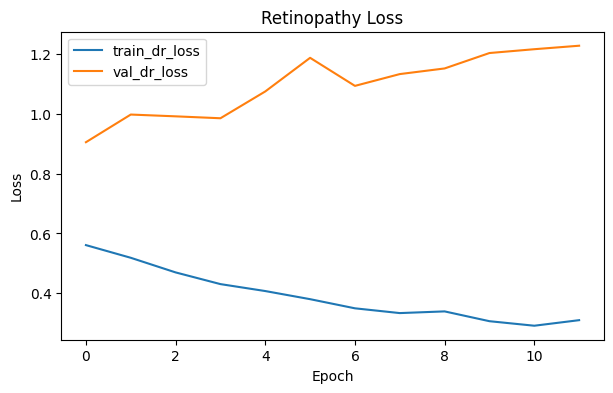

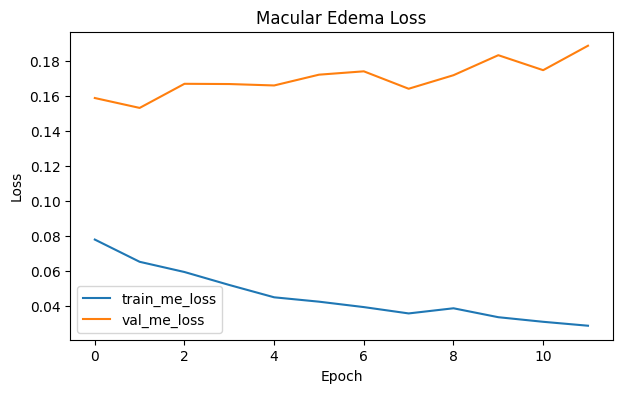

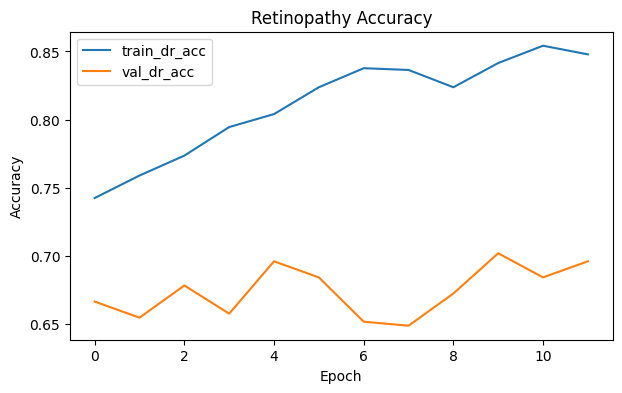

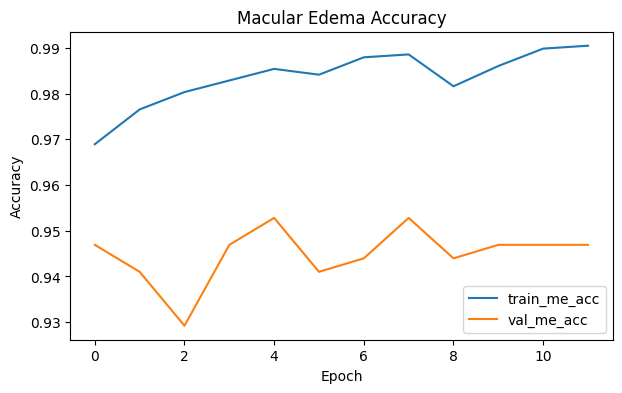

In [38]:
# Plot curves
def plot_curve(key_y, title, ylabel):
    plt.figure(figsize=(7,4))
    plt.plot(history[key_y], label=key_y)
    if key_y.replace('train', 'val') in history:
        plt.plot(history[key_y.replace('train', 'val')], label=key_y.replace('train','val'))
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel(ylabel); plt.legend(); plt.show()

plot_curve("train_dr_loss", "Retinopathy Loss", "Loss")
plot_curve("train_me_loss", "Macular Edema Loss", "Loss")
plot_curve("train_dr_acc",  "Retinopathy Accuracy", "Accuracy")
plot_curve("train_me_acc",  "Macular Edema Accuracy", "Accuracy")

C:\Users\Iamsc\AppData\Local\Temp\ipykernel_30320\28107235.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("retina_multitask_best.pth",

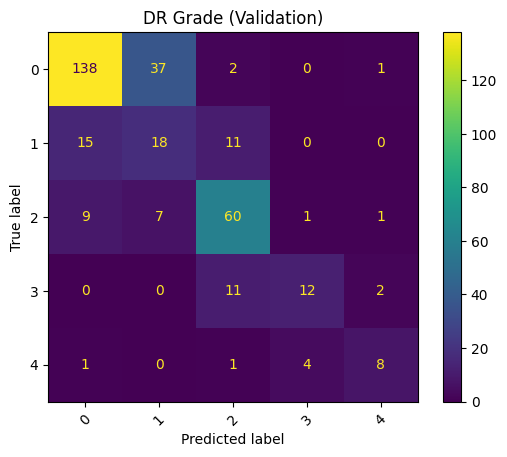

              precision    recall  f1-score   support

        DR_0       0.85      0.78      0.81       178
        DR_1       0.29      0.41      0.34        44
        DR_2       0.71      0.77      0.74        78
        DR_3       0.71      0.48      0.57        25
        DR_4       0.67      0.57      0.62        14

    accuracy                           0.70       339
   macro avg       0.64      0.60      0.61       339
weighted avg       0.72      0.70      0.71       339



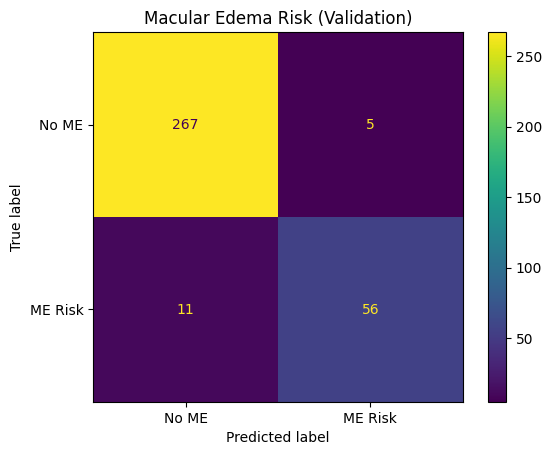

              precision    recall  f1-score   support

       No_ME       0.96      0.98      0.97       272
          ME       0.92      0.84      0.88        67

    accuracy                           0.95       339
   macro avg       0.94      0.91      0.92       339
weighted avg       0.95      0.95      0.95       339



In [44]:
def collect_preds(loader):
    model.eval()
    all_dr_t, all_dr_p = [], []
    all_me_t, all_me_p = [], []
    names = []
    with torch.no_grad():
        for imgs, dr_t, me_t, fnames, _ in loader:
            imgs = imgs.to(DEVICE)
            dr_logits, me_logits = model(imgs)
            dr_p = dr_logits.argmax(1).cpu().numpy()
            me_p = me_logits.argmax(1).cpu().numpy()
            all_dr_p.extend(dr_p); all_me_p.extend(me_p)
            all_dr_t.extend(dr_t.numpy()); all_me_t.extend(me_t.numpy())
            names.extend(fnames)
    return np.array(all_dr_t), np.array(all_dr_p), np.array(all_me_t), np.array(all_me_p), names

# Load best model for eval
model.load_state_dict(torch.load("retina_multitask_best.pth", map_location=DEVICE))

val_dr_t, val_dr_p, val_me_t, val_me_p, _ = collect_preds(valid_loader)

# DR head confusion matrix (indices mapped back to original class values)
cm_dr = confusion_matrix(val_dr_t, val_dr_p, labels=range(num_dr_classes))
disp = ConfusionMatrixDisplay(cm_dr, display_labels=[str(c) for c in train_ds.dr_classes])
disp.plot(xticks_rotation=45); plt.title("DR Grade (Validation)"); plt.show()
print(classification_report(val_dr_t, val_dr_p, target_names=[f"DR_{c}" for c in train_ds.dr_classes]))

# ME head confusion matrix
cm_me = confusion_matrix(val_me_t, val_me_p, labels=[0,1])
disp = ConfusionMatrixDisplay(cm_me, display_labels=["No ME", "ME Risk"])
disp.plot(xticks_rotation=0); plt.title("Macular Edema Risk (Validation)"); plt.show()
print(classification_report(val_me_t, val_me_p, target_names=["No_ME", "ME"]))


# Test Set Evaluation

In [45]:
# Rebuild just the test loader without multiprocessing because errors are occurring in multiprocessing
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False
)

test_dr_t, test_dr_p, test_me_t, test_me_p, test_names = collect_preds(test_loader)
test_dr_acc = (test_dr_t == test_dr_p).mean()
test_me_acc = (test_me_t == test_me_p).mean()
print(f"Test Accuracy — DR: {test_dr_acc:.3f}, ME: {test_me_acc:.3f}")

# (Optional) write the CSV again
dr_idx_to_orig = {i: v for i, v in enumerate(train_ds.dr_classes)}
test_df_out = pd.DataFrame({
    "Image name": test_names,
    "Pred DR grade (orig)": [dr_idx_to_orig[i] for i in test_dr_p],
    "True DR grade (orig)": [dr_idx_to_orig[i] for i in test_dr_t],
    "Pred ME risk": test_me_p,
    "True ME risk": test_me_t
})
test_df_out.to_csv("test_predictions.csv", index=False)
print("Saved test predictions to test_predictions.csv")

Test Accuracy — DR: 0.663, ME: 0.959
Saved test predictions to test_predictions.csv


In [46]:
# Generate results summary table
results_summary = pd.DataFrame({
    "Task": ["Retinopathy Grade", "Macular Edema Risk"],
    "Training Accuracy": [tr_dr_a, tr_me_a],
    "Validation Accuracy": [va_dr_a, va_me_a],
    "Test Accuracy": [test_dr_acc, test_me_acc]
})

print("Summary of Model Performance")
display(results_summary.round(3))


Summary of Model Performance


,Task,Training Accuracy,Validation Accuracy,Test Accuracy
0,Retinopathy Grade,0.848,0.696,0.663
1,Macular Edema Risk,0.990,0.947,0.959


# Inference on a Single Image
- Demo Purposes

In [42]:
def predict_one(img_path):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    x = valid_tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        dr_logits, me_logits = model(x)
        dr_idx = dr_logits.argmax(1).item()
        me_idx = me_logits.argmax(1).item()
    return train_ds.idx_to_dr[dr_idx], me_idx

# Example:
# demo_path = resolve_image_path(TEST_IMG_DIR, 'IMAGE_01324.png')
# predict_one(demo_path)

# Save Final Model

In [43]:
# Save final (already saved best during training)
torch.save(model.state_dict(), "retina_multitask_final.pth")
print("Saved retina_multitask_final.pth")

Saved retina_multitask_final.pth


# Grad-CAM for the Two-Head Model
- Code given by ChatGPT

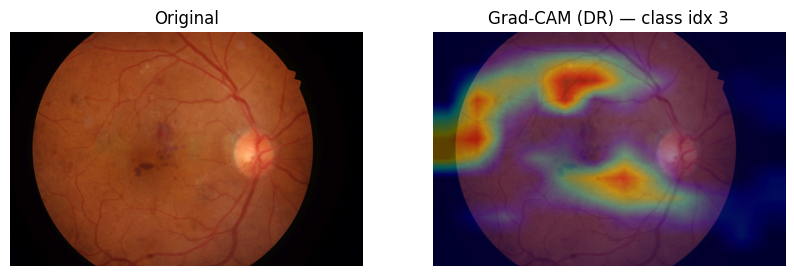

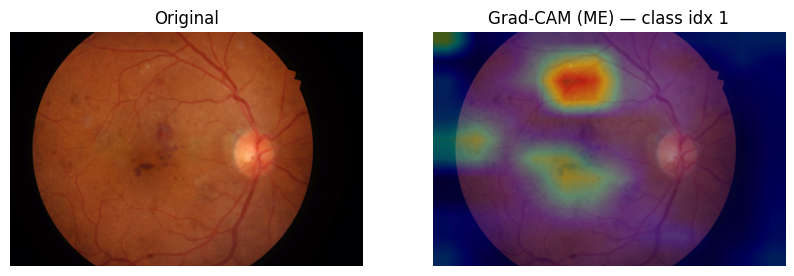

In [28]:
# === Grad-CAM for MultiTaskResNet ====================================
# Hooks into the last conv layer (layer4[-1].conv3) of ResNet50 backbone
# and generates CAMs for either head ("dr" or "me").

import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # forward hook: save activations
        self.fwd_handle = target_layer.register_forward_hook(self._forward_hook)
        # backward hook: save gradients
        self.bwd_handle = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        # grad_out is a tuple; we want gradients w.r.t. the activations
        self.gradients = grad_out[0].detach()

    def remove_hooks(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

    def _compute_cam(self):
        """
        activations: [B, C, H, W]
        gradients:   [B, C, H, W]
        returns cam: [B, H, W] in [0,1]
        """
        B, C, H, W = self.activations.shape
        # global average pool the gradients across spatial dims -> [B, C, 1, 1]
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)            # [B, C, 1, 1]
        cam = (weights * self.activations).sum(dim=1)                      # [B, H, W]
        cam = torch.relu(cam)
        # normalize per-sample to [0,1]
        cam_min = cam.view(B, -1).min(dim=1)[0].view(B, 1, 1)
        cam_max = cam.view(B, -1).max(dim=1)[0].view(B, 1, 1)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-6)
        return cam

    def generate(self, images, target_head="dr", target_index=None):
        """
        images: tensor [B,3,H,W] already on DEVICE with valid_tfms applied
        target_head: "dr" or "me"
        target_index: class index (if None, uses the model's argmax per head)
        returns:
          preds_idx: [B] predicted (or used) indices for chosen head
          cams: list of [H,W] numpy arrays in [0,1]
          logits: raw logits tensor for chosen head
        """
        self.model.eval()
        images.requires_grad_(True)

        self.model.zero_grad(set_to_none=True)
        dr_logits, me_logits = self.model(images)

        if target_head == "dr":
            logits = dr_logits
        elif target_head == "me":
            logits = me_logits
        else:
            raise ValueError("target_head must be 'dr' or 'me'")

        if target_index is None:
            class_indices = logits.argmax(dim=1)
        else:
            # broadcast a single int or accept a per-sample tensor
            if isinstance(target_index, int):
                class_indices = torch.full((images.size(0),), target_index, dtype=torch.long, device=images.device)
            else:
                class_indices = target_index.to(images.device)

        # Build a scalar by summing selected logits so we can call backward once
        selected_logits = logits[torch.arange(images.size(0)), class_indices]
        target_scalar = selected_logits.sum()
        target_scalar.backward(retain_graph=True)

        # Compute CAMs
        cams_tensor = self._compute_cam()  # [B, h, w]
        cams = [cams_tensor[i].detach().cpu().numpy() for i in range(images.size(0))]
        preds_idx = class_indices.detach().cpu().numpy()
        return preds_idx, cams, logits.detach()

def overlay_cam_on_pil(pil_img, cam_0to1, alpha=0.35):
    """
    Overlays a CAM (H,W in [0,1]) on a PIL image and returns a PIL image.
    """
    img = np.array(pil_img.convert("RGB"))
    H, W = img.shape[:2]
    cam_resized = cv2.resize(cam_0to1, (W, H))
    heatmap = (cam_resized * 255.0).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)[:, :, ::-1]  # BGR->RGB
    overlay = (alpha * heatmap + (1 - alpha) * img).astype(np.uint8)
    return Image.fromarray(overlay)

# === Create a Grad-CAM object targeting the last conv of layer4 ======
# For ResNet50 bottleneck, the last conv in the final block is layer4[-1].conv3
target_layer = model.backbone.layer4[-1].conv3
gradcam = GradCAM(model, target_layer)

def gradcam_on_path(img_path, head="dr", class_idx=None, show=True):
    """
    Convenience: run Grad-CAM on a single image path.
    Uses valid_tfms for deterministic preprocessing.
    Returns (pred_idx, cam_pil_overlay).
    """
    pil = Image.open(img_path).convert("RGB")
    x = valid_tfms(pil).unsqueeze(0).to(DEVICE)
    pred_idx, cams, logits = gradcam.generate(x, target_head=head, target_index=class_idx)
    overlay_pil = overlay_cam_on_pil(pil, cams[0], alpha=0.35)

    if show:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(pil); plt.axis("off"); plt.title("Original")
        plt.subplot(1,2,2); plt.imshow(overlay_pil); plt.axis("off")
        title = f"Grad-CAM ({'DR' if head=='dr' else 'ME'}) — class idx {int(pred_idx[0])}"
        plt.title(title)
        plt.show()
    return int(pred_idx[0]), overlay_pil

# === Example usage ====================================================
# demo_img = resolve_image_path(TEST_IMG_DIR, 'IMAGE_01418.png')
# pred_dr_idx, dr_cam = gradcam_on_path(demo_img, head="dr", class_idx=None, show=True)
# pred_me_idx, me_cam = gradcam_on_path(demo_img, head="me", class_idx=None, show=True)
demo_img = resolve_image_path(TEST_IMG_DIR, 'IMAGE_00006.png')
pred_dr_idx, dr_cam = gradcam_on_path(demo_img, head="dr", class_idx=None, show=True)
pred_me_idx, me_cam = gradcam_on_path(demo_img, head="me", class_idx=None, show=True)

# Optional: batch demo — visualize first N from a loader
def gradcam_batch_demo(loader, head="dr", n=6):
    model.eval()
    images_shown = 0
    for imgs, dr_t, me_t, fnames, _ in loader:
        imgs = imgs.to(DEVICE)
        with torch.no_grad():
            _ = model(imgs)  # populate activations on forward

        # For CAM we need gradients, so re-run with grad
        pred_idx, cams, logits = gradcam.generate(imgs, target_head=head, target_index=None)

        for i in range(min(n, imgs.size(0))):
            # Convert back to PIL for overlay (use the *un-normalized* image)
            pil_raw = Image.open(resolve_image_path(TEST_IMG_DIR, fnames[i])) if loader is test_loader else Image.open(resolve_image_path(VALID_IMG_DIR, fnames[i]))
            overlay = overlay_cam_on_pil(pil_raw, cams[i], alpha=0.35)
            plt.figure(figsize=(8,3))
            plt.subplot(1,2,1); plt.imshow(pil_raw); plt.axis("off"); plt.title(f"{fnames[i]}")
            plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off"); 
            label_txt = f"{'DR' if head=='dr' else 'ME'} pred idx: {pred_idx[i]}"
            plt.title(label_txt)
            plt.show()
            images_shown += 1
            if images_shown >= n:
                return

# Example:
# gradcam_batch_demo(valid_loader, head="dr", n=4)
# gradcam_batch_demo(valid_loader, head="me", n=4)